## Time series Forecasting
Using previous results to predict future values.
1. Process the dataset
process the null values
convert the time into datetime format and set it as index
2. Find the optimal p,d,q for ARIMA model
 - p: Number of autoregressive lags
 - d: Order of differencing required to make the series stationary
 - q: Number of moving average lags
3. Fit the model
4. Predict the future values
 - get prediction
 - get forcast
5. Evaluate with MSE or RMSE
 - Mean Absolute Percentage Error (MAPE)

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import warnings

In [8]:
passenger=pd.read_csv("/Users/yanzhenlei/Desktop/Project/arima/AirPassengers.csv")

In [11]:
passenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [10]:
passenger['Month']=pd.to_datetime(passenger['Month'],format='%Y-%m-%d')

In [12]:
passenger.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [15]:
passenger.set_index(['Month'])

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [16]:
passenger=passenger.groupby('Month',as_index=True).agg({'#Passengers':
                                                     'sum'})

<AxesSubplot:xlabel='Month'>

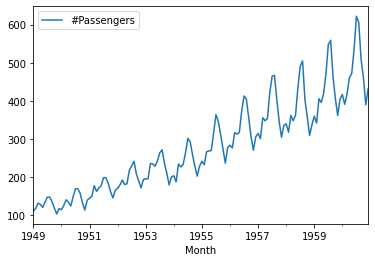

In [17]:
passenger.plot()

### ARIMA 
- p is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- d is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- q is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

In [51]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [53]:
train_data = passenger['1949-01-01':'1959-12-01']
test_data = passenger['1960-01-01':'1960-12-01']
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [61]:
print(min(AIC))
print(SARIMAX_model[AIC.index(min(AIC))])

618.2055121568379
[(3, 1, 0), (3, 1, 1, 12)]


### Fit the model

In [62]:
model = sm.tsa.statespace.SARIMAX(train_data,
                                            order=(3,1,0),
                                            seasonal_order=(3,1,1,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

result_final = mod.fit()

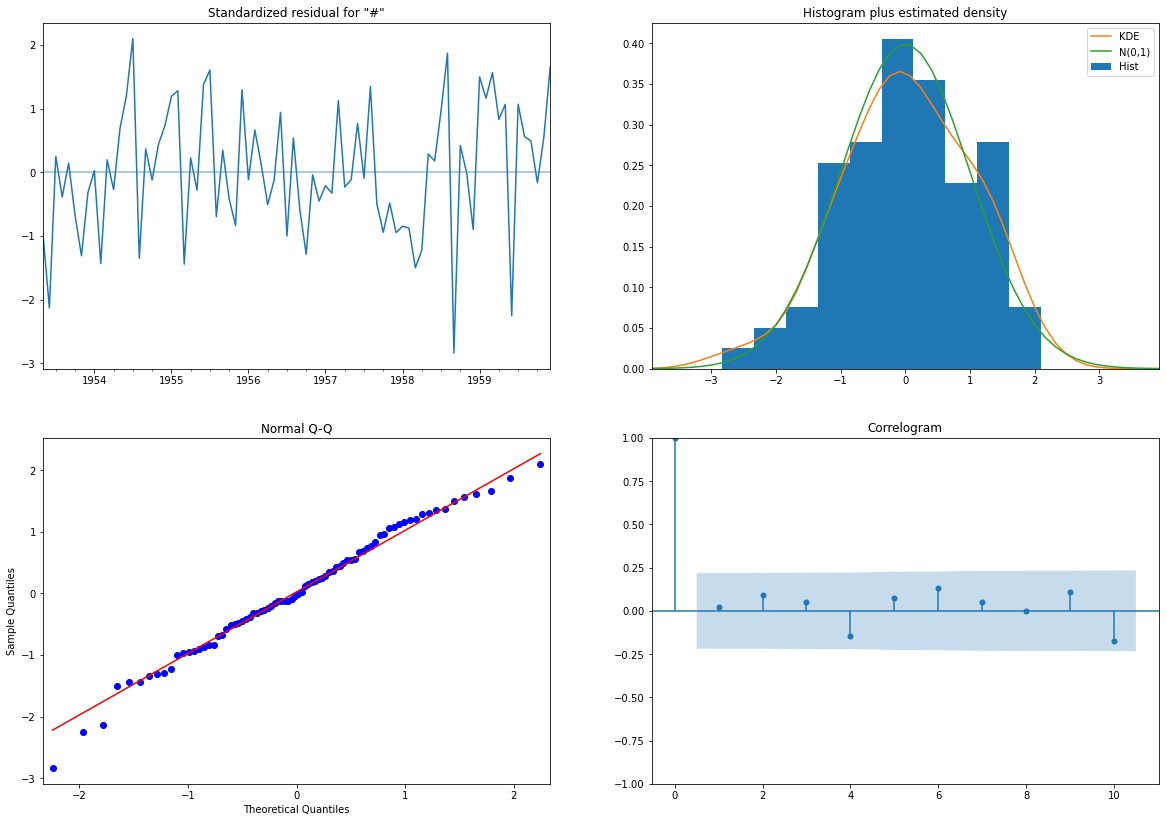

In [63]:
result_final.plot_diagnostics(figsize=(20, 14))
plt.show()

1. STD not seasonal
2. normal distributed
3. QQ plot around 0
4. Corrleogram beyond 1 within the range

### Results

In [65]:
passenger

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [72]:
pre0=result_final.get_prediction(start='1958-01-01',dynamic=False)
pre0_ci=pre0.conf_int()
pre1=result_final.get_prediction(start='1958-01-01',dynamic=True)
pre1_ci=pre1.conf_int()
pre2=result_final.get_forecast('1962-12-01')
pre2_ci=pre2.conf_int()

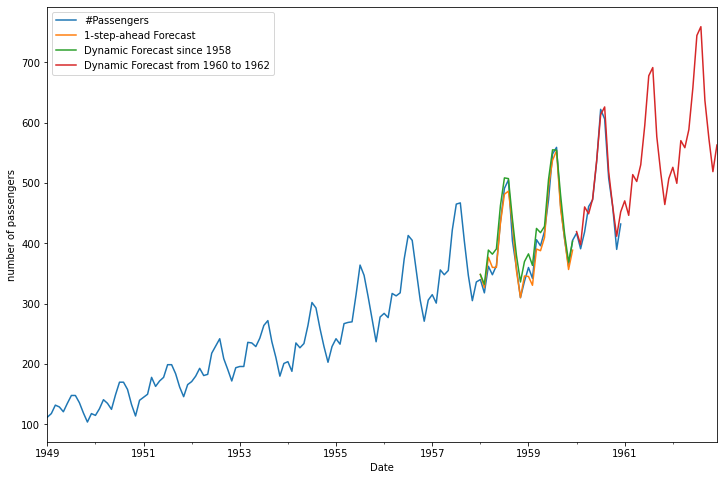

In [79]:
passenger.plot(label='orginal data')
pre0.predicted_mean.plot(label='1-step-ahead Forecast',figsize=(12,8))
pre1.predicted_mean.plot(label='Dynamic Forecast since 1958',figsize=(12,8))
pre2.predicted_mean.plot(label='Dynamic Forecast from 1960 to 1962',figsize=(12,8))
plt.legend()
plt.xlabel('Date')
plt.ylabel('number of passengers')
plt.show()

### Evaluations

In [83]:
predictions=pre2.predicted_mean['1960-01-01':'1960-12-01']
truth=list(itertools.chain.from_iterable(test_data.values))
MAPE=np.mean(np.abs(truth-predictions)/truth)*100
print("MAPE:{:.2f}%".format(MAPE))

MAPE:2.72%
